<a href="https://colab.research.google.com/github/FSMLP/DLP101/blob/main/L2_Revisiting_CNN_Deal_with_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recap of Last Lecture:

- In the last class we began by introducing the field of **Computer Vision**, it's wide-ranging applications and reflecting on why it's hard!
- We then saw how adding CNN Blocks inplace of MLPs improved overall performance of our model on an image dataset. 
- After that, we delved into the intuition behind CNNs, it's various components and how each of them worked.

## Agenda for this Lecture:

- This lecture is divided into two parts: In Part 1,  we will **code a Convolution Block from scratch** and in Part 2, we will see ways to deal with the **Issue of Overfitting** in CNNs.
- Part 1 will be focussed on understanding the working of **Convolution** and **Pooling** functions by implementing it from scratch.
- In Part 2 we will broadly cover two classes of regularization techniques, 
    1. Modifications in **Model Pipeline** (architecture, loss functions etc.) 
    2. Modifications in **Data Pipeline** (data augmentations)

# Part 1. Convolution Block From Scratch

In this segment, we will extend our understanding about Convolution and MaxPooling by implementing them from scratch (using Numpy). Using some predefined filters, we will then apply convolution operation on a sample image.

### Setup (Import Statements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage.io import imread, imshow
from skimage.transform import rescale, resize

### 1. Implementation of Conv Block (Convolution + Non-Linearity + Pooling) using Numpy

- Convolution:
    - In this function, we take in an image and a kernel (2D matrix), along with two optional parameters; padding and strides (both integers) and return the convolved image.
    - We iterate through every pixel in the image, and taking it as the central pixel, we perform element-wise multiplication of the surrounding pixels with the kernel pixels; finally replacing it with the net sum of those values.

- Non-Linearity:
    - We use ReLU as our non-linear function and apply it to every pixel in the image.
    - Notice that here we use a vectorized and more efficient implementation.
- Pooling:
    - We implement MaxPooling, in much the same way as Convolution, except that this time, we don't apply kernel over the image, rather a max function over a region of image surrounding the central pixel. That region is determined by the `size` parameter.

In [2]:
# Convolution function
def convolve2D(image, kernel, padding, strides):
    # Gather Shapes of Kernel + Image + Padding
    (xImgShape, yImgShape) = image.shape[: 2]
    (xKernShape, yKernShape) = kernel.shape[: 2]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))
  
    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding * 2, image.shape[1] + padding * 2))
        imagePadded[int(padding):int(-1 * padding), int(padding) : int(-1 * padding)] = image
        # print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in np.arange(0, image.shape[1], strides):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(0, image.shape[0], strides):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x : x + xKernShape, y : y + yKernShape]).sum()
                except:
                    break

    return output

# Non-linearity (ReLU) function
def relu(feature_map):
    relu_out = np.where(feature_map > 0, feature_map, 0)
    return relu_out

# Pooling (MaxPool) function
def pooling(feature_map, size, stride):
    # Shape of pooling
    xOutput = int(((feature_map.shape[0] - size) / stride) + 1)
    yOutput = int(((feature_map.shape[1] - size) / stride) + 1)
    pool_output = np.zeros((xOutput, yOutput))

    # Iterate through image
    x2 = 0
    for y in np.arange(0,feature_map.shape[1],stride):
        # Exit Convolution
        if y > feature_map.shape[1] - size:
            break
        y2 = 0
        # Only Convolve if y has gone down by the specified Strides
        if y % stride == 0:
          for x in np.arange(0, feature_map.shape[0], stride):
              # Go to next row once kernel is out of bounds
              if x > feature_map.shape[0] - size:
                  break
              try:
                  # Only Convolve if x has moved by the specified Strides
                  if x % stride == 0:
                      pool_output[x2, y2] =  np.max([feature_map[y : y+size,  x : x+size]])
                      y2 += 1
              except:
                  break
          x2 += 1

    return pool_output

### 2. Common Filters
- In Lecture 1, we had already looked at some of the common filters, namely Horizontal and Vertical Filter.  
    - **Horizontal Filter** -
        \begin{bmatrix}
        1&  0&  -1\\ 
        1&  0&  -1\\ 
        1&  0&  -1
        \end{bmatrix}
    - **Vertical Filter** -
        \begin{bmatrix}
        1&  1&  1\\ 
        0&  0&  0\\ 
        -1&  -1&  -1
        \end{bmatrix}

- In this lecture, we will introduce two new filters and operate with it; namely,
    1. **Sharpen Filter** - As the name suggests, it is used to enhance the edges of objects and adjust the contrast and the shade characteristics in a image, with a matrix like the one shown below:
<br>
\begin{bmatrix}
0&  -1&  0\\ 
-1&  5& -1\\ 
0&  -1& 0
\end{bmatrix}
    2. **Blur Filter** - It has the effect of smoothening of image, by averaging all pixels surrounding a central pixel and replacing it with the averaged value. A 3x3 average filter is shown below:
    <br>
\begin{bmatrix}
\frac{1}{9}&  \frac{1}{9}&  \frac{1}{9}\\ 
\frac{1}{9}&  \frac{1}{9}&  \frac{1}{9}\\ 
\frac{1}{9}&  \frac{1}{9}&  \frac{1}{9}
\end{bmatrix}

In [3]:
# construct average blurring kernels used to smooth an image
blur_filter = np.ones((3, 3), dtype='float') * (1.0 / (3 * 3))


# construct a sharpening filter
sharpen_filter = np.array((
     [0, -1,  0],
     [-1, 5, -1],
     [0, -1,  0]), dtype='int')

kernelBank = [("blur",blur_filter), ("sharpen",sharpen_filter)]

### 3. Apply Conv Block on a Sample Image using above Filters


[INFO] applying blur kernel
[INFO] applying sharpen kernel


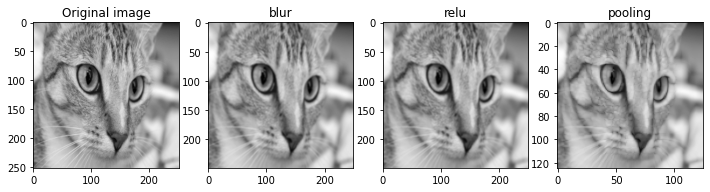

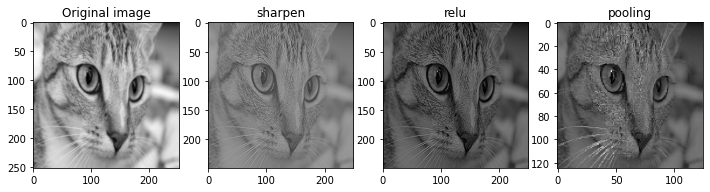

In [4]:
img = skimage.data.chelsea()
# Converting the image into gray.
gray = skimage.color.rgb2gray(img)
gray = resize(gray, (252, 252))

for (kernelName, K) in kernelBank:
    print("[INFO] applying {} kernel".format(kernelName))
    output = convolve2D(gray, K, 0, 1)
    act = relu(output)
    pool = pooling(act, size=2, stride=2)

    f, axarr = plt.subplots(1, 4, figsize=(12, 12))
    axarr[0].imshow(gray, cmap='gray')
    axarr[1].imshow(output, cmap='gray')
    axarr[2].imshow(act, cmap='gray')
    axarr[3].imshow(pool, cmap='gray')

    axarr = axarr.ravel()
    axarr[0].set_title("Original image")
    axarr[1].set_title(kernelName)
    axarr[2].set_title("relu")
    axarr[3].set_title("pooling")

- In the above example, we saw how different functions in Conv-Block operate on an Image and what visual changes they create.
- In other words, we showed how Forward Propagation actually works in a Conv-Block with the help of predefined filters.
- In the next lecture, we will implement both forward and backward propagation from scratch and train it on a custom dataset.  

But for now, let's move on to the next Part, which is about dealing with Overfitting in CNNs.


#Part 2. Tackling Overfitting

There are broadly two ways in which we can reduce overfitting -

- #### ***1. Modifications in Model Pipeline:***  Improving ***Network*** Configuration to solve over-parametrization
- #### ***2. Modifications in Data Pipeline:***  Augmenting ***Dataset*** to increase the number of samples

**But before even talking about these techniques, let's revisit the problem statement and the baseline model we developed in the last lecture** - 

### Setup 

#### Download Data

We are going to use the same collection of real-world clothing images dataset as in the first lecture, opensourced [here](https://github.com/alexeygrigorev/clothing-dataset-small).  

You can read more about the dataset in this [blog post](https://medium.com/data-science-insider/clothing-dataset-5b72cd7c3f1f).

In [5]:
!gdown https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC

Downloading...
From: https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC
To: /content/clothing-dataset-small.zip
100% 106M/106M [00:03<00:00, 28.1MB/s] 


In [6]:
!unzip /content/clothing-dataset-small.zip

Archive:  /content/clothing-dataset-small.zip
   creating: clothing-dataset-small/
  inflating: clothing-dataset-small/.DS_Store  
   creating: clothing-dataset-small/test/
   creating: clothing-dataset-small/test/skirt/
  inflating: clothing-dataset-small/test/skirt/f4b934fc-e326-4f72-b535-53288b8b82d3.jpg  
  inflating: clothing-dataset-small/test/skirt/491982c3-3e90-431e-99e6-b14ecea36384.jpg  
  inflating: clothing-dataset-small/test/skirt/24963db3-649c-4f04-8da3-0375ede8e0a6.jpg  
  inflating: clothing-dataset-small/test/skirt/32b99302-cec7-4dec-adfa-3d4029674209.jpg  
  inflating: clothing-dataset-small/test/skirt/0558b2c5-be00-49de-b27f-8c88114ac36f.jpg  
  inflating: clothing-dataset-small/test/skirt/95e66e02-b4ed-4fe9-b538-db6bac4fb7df.jpg  
  inflating: clothing-dataset-small/test/skirt/2001dec1-1e0a-4c11-9d15-120b019b3dea.jpg  
  inflating: clothing-dataset-small/test/skirt/b0e05193-cc92-4935-88d7-e71a1b19dd4b.jpg  
  inflating: clothing-dataset-small/test/skirt/309829b2-6d1

#### Import Statements

In [1]:
import os
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(111)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
%matplotlib inline

## 0. Revisiting CNNs

Let's start from where we left off- 

[A typical CNN training pipeline]

- Problem Type: Image Classification
- Dataset: Clothing Dataset, 10 classes
- Model: 2-block (Conv+Maxpool) CNN model
    - Performance: ~52% accuracy on test dataset

These results are better than MLPs but far from perfect.   
In this module, we will investigate the reasons for poor performance and seek solution to improve the accuracy of our model.

Let's start with this as our **Baseline Model** and iteratively improve upon it to build a highly performant system. 

[Poll] Random Guess how much improvement we will be able to make (in terms of test accuracy) and in how many iterations (number of modifications)?

### Baseline Model

This is the same CNN model which we used in the previous module to train our clothing dataset.

Loading Data

In [2]:
def load_data(base_dir="clothing-dataset-small"):    
    # checking if the data folders are present
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/validation") and os.path.exists(f"{base_dir}/test")

    print('\nLoading Data...')
    train_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/train", shuffle=True, label_mode='categorical'
    )
    val_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/validation", shuffle=False, label_mode='categorical'
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/test", shuffle=False, label_mode='categorical'
    )
    return train_data, val_data, test_data, train_data.class_names

In [3]:
train_data, val_data, test_data, class_names = load_data()


Loading Data...
Found 3068 files belonging to 10 classes.
Found 341 files belonging to 10 classes.
Found 372 files belonging to 10 classes.


Data Preprocessing: Resizing, Standardization

In [4]:
def preprocess(train_data, val_data, test_data, target_height=128, target_width=128):

    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [5]:
train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

Model Architecture

In [6]:
def baseline(height=128, width=128):
    num_classes = 10
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [7]:
model = baseline()
model.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 256)               16777472  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16,780,490
Trainable params: 16,780,490
Non-trainable params: 0
_____________________________________________

Compile and Train

In [8]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint"):
    epochs = 10
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [9]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
96/96 [==============================] - 19s 131ms/step - loss: 2.9412 - accuracy: 0.3409 - val_loss: 1.7299 - val_accuracy: 0.4545
Epoch 2/10
96/96 [==============================] - 7s 69ms/step - loss: 1.4002 - accuracy: 0.5548 - val_loss: 1.4634 - val_accuracy: 0.5249
Epoch 3/10
96/96 [==============================] - 7s 69ms/step - loss: 0.9621 - accuracy: 0.7060 - val_loss: 1.3911 - val_accuracy: 0.5337
Epoch 4/10
96/96 [==============================] - 7s 69ms/step - loss: 0.6205 - accuracy: 0.8162 - val_loss: 1.4282 - val_accuracy: 0.5836
Epoch 5/10
96/96 [==============================] - 7s 65ms/step - loss: 0.3652 - accuracy: 0.9074 - val_loss: 1.4748 - val_accuracy: 0.5806
Epoch 6/10
96/96 [==============================] - 7s 68ms/step - loss: 0.2141 - accuracy: 0.9527 - val_loss: 1.5245 - val_accuracy: 0.5865
Epoch 7/10
96/96 [==============================] - 7s 69ms/step - loss: 0.1244 - accuracy: 0.9804 - val_loss: 1.6673 - val_accuracy: 0.5894
Epoch 8/10


Plot Train and Validation Accuracy

In [10]:
# helper function to annotate maximum values in the plots
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

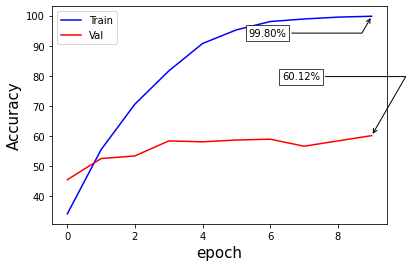

In [11]:
plot_accuracy(model_fit)

Analyze Result on Test Dataset

In [12]:
def print_accuracy_stats(model, ds, class_names):
    model.load_weights("/tmp/checkpoint")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("/tmp/checkpoint")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()


Test Accuracy: 51.34%



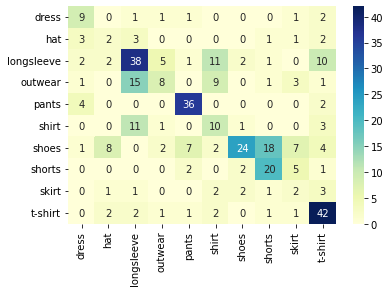

In [13]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

#### What is the most apparent issue with the plots above?
**Validation Accuracy very low as compared to Training Accuracy**
(better known as Overfitting)

#### How do we solve the Overfitting in ML?

Overfitting = More Trainable Parameters, Less Training Samples
***Solutions -***
1. More Data, Data Augmentation
2. Reducing Complexity of Model Architecture (Smaller Model)
3. Adding Regularizer to Model
4. Adding Regularizer to Loss Function

## **1.** Modifications in Model Pipeline

The baseline network has ~4.2 million parameters and just over 3000 images for training. This results in overparamterization of the network making it prone to overfit. One way to tackle this would be to remove some layers from the network. But since it's already a small network, that would badly affect the performance on both training/validation set (You can try yourself to see that!). So what else can we do?

***HINT: Look at `model.summary()` carefully!***

We find that over ~99% of the parameters are associated with just one layer, and that's not even the Convolutional layer. Although we introduced CNN in the model architecture, the number of trainable parameters as a result of that is just ~5000 which is 1000 times less than that of the Dense Layers in the architecture.

The reason for it is that when we flatten the 3D matrix of shape 32x32x32 into 1D, the number of connections from that layer to dense layer explodes exponentially (no weight sharing in MLP).

In order to avoid this, we will try do two things:
1. Reduce the 3D volume before the flatten layer by using more Convolution blocks.
2. Replace the flatten layer by `GlobalAveragePooling2D`  

### **Modification #1**

In [14]:
def arch_1(height=128, width=128):
    num_classes = 10
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [15]:
model = arch_1()
model.summary()

Model: "model_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       

In [16]:
def compile_train_v1(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint"):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [17]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
96/96 [==============================] - 8s 70ms/step - loss: 2.1358 - accuracy: 0.2562 - val_loss: 2.1571 - val_accuracy: 0.2375
Epoch 2/10
96/96 [==============================] - 7s 67ms/step - loss: 2.0562 - accuracy: 0.2995 - val_loss: 2.0414 - val_accuracy: 0.2962
Epoch 3/10
96/96 [==============================] - 7s 68ms/step - loss: 1.8996 - accuracy: 0.3592 - val_loss: 2.0045 - val_accuracy: 0.3138
Epoch 4/10
96/96 [==============================] - 8s 76ms/step - loss: 1.7706 - accuracy: 0.3996 - val_loss: 1.8253 - val_accuracy: 0.3783
Epoch 5/10
96/96 [==============================] - 7s 67ms/step - loss: 1.6307 - accuracy: 0.4478 - val_loss: 1.6981 - val_accuracy: 0.4370
Epoch 6/10
96/96 [==============================] - 8s 77ms/step - loss: 1.4800 - accuracy: 0.4954 - val_loss: 1.5552 - val_accuracy: 0.5103
Epoch 7/10
96/96 [==============================] - 7s 68ms/step - loss: 1.3218 - accuracy: 0.5489 - val_loss: 1.4115 - val_accuracy: 0.5161
Epoch 8/10
96

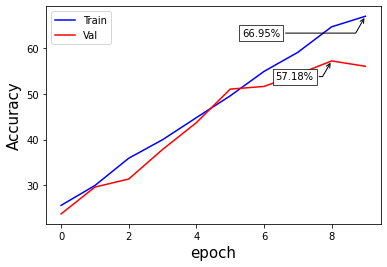

In [18]:
plot_accuracy(model_fit)


**Unbelievable!**  
With just two modifications in the architecture, we can see the model performing much better and the problem of overfitting vanish.  

This is good news, but something seems not right about the above plots!   
#### **Can you guess what is wrong with the above plots?**  

It seems the model was still improving when we stopped training leading to ***underfitting***!  
So, let's continue training for more number of epochs. **But how many more epochs?**  

The answer is that *we do not know*. But perhaps we can guess, by looking at the training plots. **Can you?**   

- We can stop when the val loss/accuracy curve flattens out (or do not improve any further)!  
- This technique is better known as "early stopping" and `keras` provides a readymade function for that. 
- Effectively, it stops model training, once the condition set by `EarlyStopping` is met.
- Conditions could be based on either validation loss or accuracy numbers.
- The `patience` argument determines that after how many "epochs with no improvement", training should be stopped.

Let's plugin this into our training pipeline and see if it improves the result. [not implemented yet!]

In [19]:
model = arch_1()
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
96/96 [==============================] - 8s 70ms/step - loss: 2.1403 - accuracy: 0.2546 - val_loss: 2.1996 - val_accuracy: 0.2375
Epoch 2/30
96/96 [==============================] - 7s 67ms/step - loss: 2.0337 - accuracy: 0.3057 - val_loss: 2.0004 - val_accuracy: 0.3167
Epoch 3/30
96/96 [==============================] - 7s 68ms/step - loss: 1.8697 - accuracy: 0.3686 - val_loss: 1.8894 - val_accuracy: 0.3431
Epoch 4/30
96/96 [==============================] - 7s 68ms/step - loss: 1.7364 - accuracy: 0.3934 - val_loss: 1.8785 - val_accuracy: 0.3314
Epoch 5/30
96/96 [==============================] - 7s 67ms/step - loss: 1.6249 - accuracy: 0.4430 - val_loss: 1.6701 - val_accuracy: 0.4399
Epoch 6/30
96/96 [==============================] - 7s 67ms/step - loss: 1.5061 - accuracy: 0.4866 - val_loss: 1.7306 - val_accuracy: 0.4340
Epoch 7/30
96/96 [==============================] - 7s 67ms/step - loss: 1.4371 - accuracy: 0.5121 - val_loss: 1.4936 - val_accuracy: 0.4868
Epoch 8/30
96

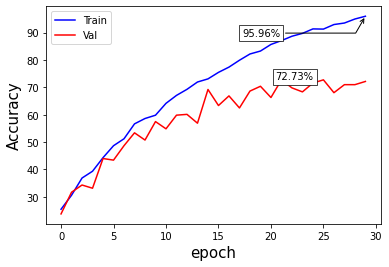

In [20]:
plot_accuracy(model_fit)


Test Accuracy: 65.59%



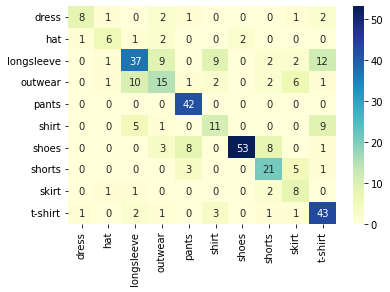

In [21]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

We see a **MASSIVE IMPROVEMENT** in the performance on test dataset, but is this the best number we can achieve, using architecture improvements?
- Most Likely, the answer is No. Many improvements on the architecture side exists and we will look into some of them in subsequent lectures. (Also, heard of NAS?)
- But before moving on, let's try one more thing in our model. We already know from previous lectures that adding Dropout and BatchNorm helps in regularizing the model, thus improving performance on validation dataset. (One question on BN, Dropout; does the introduce new "training" parameters?) Let's see it in action next.

### **Modification #2** 
1. Add Batch Normalization after every `Conv2D` and `Dense` layers.
2. Add `Dropout` after `Dense` layers

#### **Q. What is Dropout and why is it required?**
- Drops out random neurons from the network during training
- Dropout reduces overfitting by :
    - Reducing over - reliability of the network on using certain features to identify in a image
    - Dropout thus encourages the network to utilize all the features to find pattern in a image
    - Thus increasing overall generalization of our model, thus giving good model performance


- Dropout is only used during training and not while evaluating our model as
    - We want to use the capability of every learned neurons and really don't like to skip some of them randomly.

<center><img src='https://drive.google.com/uc?id=1P0w9g-BuTHUCWQ6Xcz7A_lei_bQfdTX-' height=280></center>

#### **Q. What is Batch Normalization?**
- Simply put, it normalizes the inputs to each layer to a learnt representation likely close to μ = 0.0, σ = 1.0 wrt every minibatch.
- It's a four-step process as described below:

<center><img src='https://t3638486.p.clickup-attachments.com/t3638486/c04a328b-8726-4bce-9f8d-b121e0e157ba/image.png' height=200>
<img src='https://drive.google.com/uc?id=12DwZw4uWID62jT6PJHlmzhKeEe9plhxe' height=300></center>

#### **Q. Why Batch Normalization?**

- In simple terms, just like input normalization, if all the layer inputs are normalized, then the significant outliers are less likely to impact the training process in a negative way. 
- And if they do, their impact will be much lower than without using Batch Normalization.
- This inturn makes model less sensitive to hyperparameter tuning (for eg: larger LRs won't affect much the training process).

#### **Q. How Batch Normalization Behaves during Inference?**

- When inferring e.g. the class for a new sample, you wish to normalize it based on the entire training set, as it produces better estimates and is computationally feasible.

- Hence, during inference, the Batch Normalization step goes as follows:
<center><img src='https://t3638486.p.clickup-attachments.com/t3638486/e58670bb-997f-4acb-9909-534ec0536e1d/image.png' height=100></center>, where, 𝑥∈𝑋  and 𝑋 represents the full training data.

#### **Q. Now that we have understood Dropout and BN, where should we add it to our model?**

- Emperically it has been found out that dropout works best when it is placed in-between Dense layers of an architecture with a probability of 0.5.
- Sometimes adding dropout layers after MaxPooling Layer with lower probability (0.1 to 0.25) also enhances performance.
- These are not hard-set rules, rather standard practices which people tend to follow.

- As for BatchNorm, the original paper suggested to add BN layer just after Conv Layer and before non-linearity, but later-on it was experimentally found out that placing BN layers after non-linear layers worked better. 

- Other reasoning for placing BN after both Conv and non-linear layers like ReLU comes from Statistics. If we normalize the feature distribution right after Conv Layer and pass it to the ReLU block, it will clamp the negative values from BN output to 0, effectively changing the distribution itself and defeating the purpose of normalization.




In [22]:
def arch_2(height=128, width=128):
    num_classes = 10
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [23]:
model = arch_2()
model.summary()

Model: "model_cnn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        

In [24]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
96/96 [==============================] - 9s 73ms/step - loss: 2.7027 - accuracy: 0.2552 - val_loss: 2.8881 - val_accuracy: 0.2375
Epoch 2/30
96/96 [==============================] - 7s 70ms/step - loss: 2.1552 - accuracy: 0.3556 - val_loss: 2.9065 - val_accuracy: 0.2375
Epoch 3/30
96/96 [==============================] - 7s 70ms/step - loss: 1.8535 - accuracy: 0.4374 - val_loss: 2.9095 - val_accuracy: 0.3050
Epoch 4/30
96/96 [==============================] - 7s 71ms/step - loss: 1.5557 - accuracy: 0.5039 - val_loss: 1.7833 - val_accuracy: 0.3959
Epoch 5/30
96/96 [==============================] - 7s 70ms/step - loss: 1.3379 - accuracy: 0.5678 - val_loss: 1.5049 - val_accuracy: 0.5044
Epoch 6/30
96/96 [==============================] - 7s 69ms/step - loss: 1.2205 - accuracy: 0.5988 - val_loss: 1.2197 - val_accuracy: 0.5601
Epoch 7/30
96/96 [==============================] - 7s 69ms/step - loss: 1.0185 - accuracy: 0.6571 - val_loss: 1.2142 - val_accuracy: 0.6041
Epoch 8/30
96

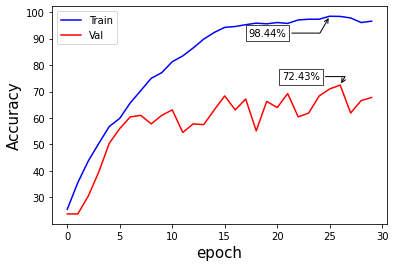

In [25]:
plot_accuracy(model_fit)

**WAIT, WAIT..SOMETHING AIN'T RIGHT HERE...**   

We see the training is not very stable here (too many fluctuations)! This was "kinda" expected since we added more chaos to the training process, for example "dropout" switches off 20% of connections randomly at every step. 


*Note: Every regularization technique induces some form of chaos to the training process.*  

#### Q.**How to solve this issue?**

**Rule of Thumb:** Fluctuating (heartbeat) plots imply that the learning rate is too high.  

So, we can try tuning it. Or a better alternative is to use a Learning Rate Scheduler and let the model train until the loss/accuracy curve flattens out (also called Early Stopping). 

In Keras, we can simply add both LR Scheduler and Early Stopping as a callback to `model.fit`.

### **Modification #3** 

#### 1. Use `ReduceLROnPlateau` as LR Scheduler and `EarlyStopping` to stop training once the loss curve plateaus.


In [26]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [27]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
96/96 [==============================] - 8s 71ms/step - loss: 2.7117 - accuracy: 0.2311 - val_loss: 2.4116 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 7s 69ms/step - loss: 2.2186 - accuracy: 0.3449 - val_loss: 2.6061 - val_accuracy: 0.2962 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 7s 69ms/step - loss: 1.9429 - accuracy: 0.4136 - val_loss: 2.0188 - val_accuracy: 0.3695 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 8s 79ms/step - loss: 1.6973 - accuracy: 0.4690 - val_loss: 1.6319 - val_accuracy: 0.4311 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 8s 79ms/step - loss: 1.5433 - accuracy: 0.5055 - val_loss: 1.4103 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 7s 68ms/step - loss: 1.3876 - accuracy: 0.5473 - val_loss: 1.3560 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 7s 69ms/step - lo

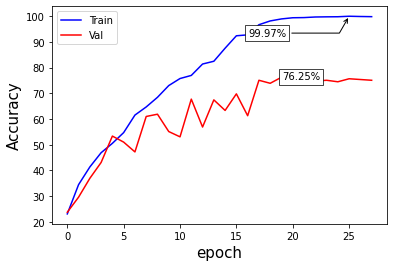

In [28]:
plot_accuracy(model_fit)


Test Accuracy: 73.39%



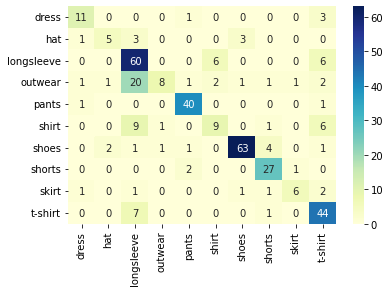

In [29]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

**Nice Improvements!**

Before moving on, let's also study the effect of adding L1/L2 Regularizer to loss functions.   
- L2 regularization reduces the impact of insignificant features, thereby, giving a generalizable model. L1 regularization removes some of the features from the model to reduce overfitting.
- In `Keras`, we add regularizers in the model definition itself.

#### Q. **What is L1 Regularization ?** 
L1 regularization, also known as L1 norm, combats overfitting by shrinking the parameters towards 0, hence making some features obsolete

- L1 Regularization can be interpreted as a form of feature selection
- Because when we assign a feature weight = 0, we remove the significance of the feature
-  If the input features of our model have weights closer to 0, our L1 norm would be sparse. 
- A selection of the input features would have weights equal to zero, and the rest would be non-zero. 

To understand L1 Regularization better, lets take an example : <br>
Supoose we want to estimate car prices using machine learning, using the features :
- Brand
- Engine power
- Fuel capacity
- Year of manufacturing
- Cabin volume

When predicting the price of a car, different features will have difference infleunce on the price. For example, it is likely that Fuel capacity of car has a lower influence on the price of a car than Engine power.


So our L1 Regularization technique would assign Fuel capacity feature with a zero weight, because it does not have significant effect on the price. We can expect Engine power and other infuential features on the car price to be assigned non-zero weights.

Mathematically L1 Regularization can be represented as :

<img src='https://drive.google.com/uc?id=10kKlUkyr849jz9bzz_5Wcb55DvK1mvKc' height=200>

Essentially, when we use L1 regularization, we are penalizing the absolute value of the weights. 

L1 Regularizaiton would produce a model that is highly generalized, and only uses a subset of input features, thus reducing the complexity of the model, thus reducing overfitting. 

#### Q. **What is L2 Regularization ?** 

- L2 Regularizaiton or L2 norm, counters overfitting by forcing weights to be small, but not making them exactly 0.

- So if we are predicting car prices again, this means that less significant features for predicting the car prices would still have some influence over the final prediction, but it would only be a small influence. 

The regularization term that we add to the loss function when performing L2 regularization is the sum of squares of all of the feature weights:

<img src='https://drive.google.com/uc?id=1Be9BvuJDV6gzO8PJtwZjMz3blG6pLczd' height=70>


So, L2 regularization returns a non-sparse solution since the weights will be non-zero (although some may be close to 0).


### **Modification #4** 
#### 1. Add L2 regularization to `Conv2D` and `Dense` layers




In [30]:
def arch_3(height=128, width=128):
    num_classes = 10
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [31]:
model = arch_3()
model.summary()

Model: "model_cnn_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 activation_12 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 activation_13 (Activation)  (None, 64, 64, 32)        

In [32]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
96/96 [==============================] - 8s 72ms/step - loss: 3.3110 - accuracy: 0.2425 - val_loss: 3.5696 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 7s 69ms/step - loss: 2.8148 - accuracy: 0.3315 - val_loss: 3.4982 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 7s 69ms/step - loss: 2.5125 - accuracy: 0.4035 - val_loss: 2.8909 - val_accuracy: 0.2991 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 7s 69ms/step - loss: 2.2153 - accuracy: 0.4782 - val_loss: 2.5834 - val_accuracy: 0.3578 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 7s 70ms/step - loss: 2.0188 - accuracy: 0.5378 - val_loss: 2.2209 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 7s 69ms/step - loss: 1.8105 - accuracy: 0.5851 - val_loss: 1.9834 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 7s 69ms/step - lo

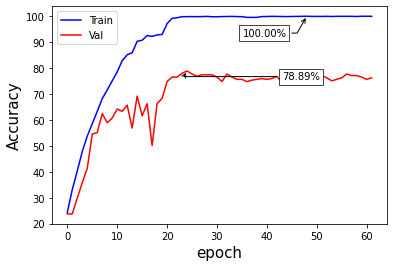

In [33]:
plot_accuracy(model_fit)


Test Accuracy: 79.30%



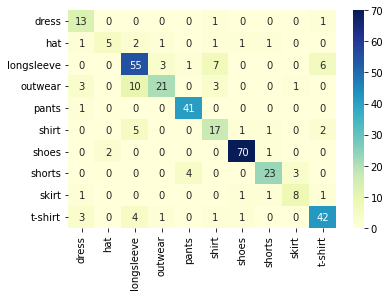

In [34]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

**Well, we can see that after adding regularization, the test accruacy improved by quite a bit!**

## **2.** Modifications in Data Pipeline (Data Augmentation)

#### What is Augmentation?

- Augmentation is a technique to `artificially increase` the amount of data by generating new data points from `existing data`. 

**How can we increase the data from existing data?**  

- By making Minor changes such as `flips, translations,brigntness,coloring, rotations etc`. 

<img src='https://drive.google.com/uc?id=15SJ7_ImxN3Ouzdx6T921JtFg0mS0P_Z4' height=200>



**How does it help with training?**  

- This leads to greater diversity of data samples being seen by the network hence decreasing the likelihood of overfitting the model on the training dataset. 

- Also it helps in reducing some of the spurious characteristics of the dataset.

#### What different sort of Augmentation strategies we can apply?

Some most common data augmentations are:
* padding
* random rotating
* re-scaling,
* vertical and horizontal flipping
* translation ( image is moved along X, Y direction)
* cropping
* zooming
* darkening & brightening/color modification
* grayscaling
* changing contrast
* adding noise
* random erasing

We will discuss some of them in detail here, along with their code in `Keras`.

#### How do we apply augmentation in `tensorflow` / `keras`?

There are many ways to apply augmentation in Tensorflow/Keras, few of them are discussed here:
1. using the Keras Preprocessing Layers, just like preprocessing functions like `resizing` and `rescaling`, keras also provides data augmentation layers like `tf.keras.layers.RandomFlip`,  `tf.keras.layers.RandomRotation`, etc. These can be used in a similar way as we used the preprocessing functions.
2. using tf.image methods like `tf.image.stateless_random_flip_up_down`, `tf.image.stateless_random_brightness`
3. using Keras ImageDataGenerator API - It provides quick, out-of-the-box suite of augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more. 

In this module, we will be using mostly option 1. Keras Preprocessing Layers for data augmentation.

Load Samples

In [35]:
# Functions to Load and Visualize Samples
# Load Sample
def load_sample(output_size=(300, 300)):
    sample = keras.utils.get_file(
        "sample.jpg", 
        "https://t3638486.p.clickup-attachments.com/t3638486/a0a4f633-2963-4e06-acae-2ad1d12eba3e/sample.jpg",
    )
    sample = keras.utils.load_img(sample, target_size=output_size)
    sample = keras.utils.img_to_array(sample)
    return sample

# Visualize Sample
def show_images(imgs, num_rows, num_cols, scale=2):
    # show augmented images in a grid layout 
    aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1]
    figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            if num_rows != 1:
                axes[i][j].imshow(imgs[i * num_cols + j].numpy().astype("uint8"))
                axes[i][j].axes.get_xaxis().set_visible(False)
                axes[i][j].axes.get_yaxis().set_visible(False)
            else:
                plt.imsave('test.png', imgs[i * num_cols + j].numpy()[0].astype("uint8"))
                # print(imgs[i * num_cols + j].numpy()[0].astype("uint8"))
                axes[j].imshow(imgs[i * num_cols + j].numpy().astype("uint8"))
                axes[j].axes.get_xaxis().set_visible(False)
                axes[j].axes.get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace=0.1, wspace=0)
    return axes

def apply(img, aug, num_rows=1, num_cols=4, scale=3):
    # apply augmentation multiple times to obtain different samples
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

#### Basic Augmentation Techniques using `tf.keras.layers.*` and `tf.image`

All these augmentation techniques will only apply if the mode is set to `training`!

In [36]:
# Required to reset the mode to training! 
tf.keras.backend.clear_session()

a. `RandomCrop`

During training, this layer will randomly choose a location to crop images down to a target size. The layer will crop all the images in the same batch to the same cropping location.

221184/211859 [===============================] - 0s 0us/step


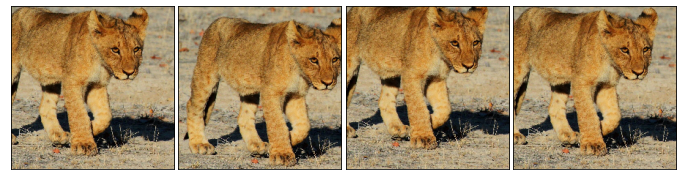

In [37]:
from keras.layers import RandomCrop

sample = load_sample(output_size=(300, 300))
aug_layer = RandomCrop(
    height = 224,
    width = 224,
)

apply(sample, aug_layer)

In [38]:
# Alternative Implementation using tf.image
random_crop = tf.image.random_crop(value=sample, size=(224, 224, 3))

b. `RandomTranslation` 

This layer will apply random translations to each image during training, filling empty space according to `fill_mode`.

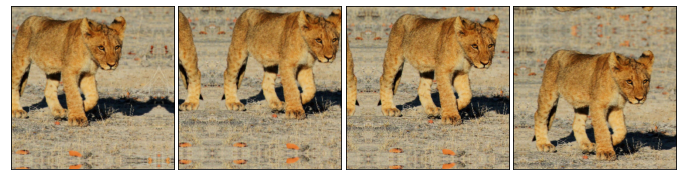

In [39]:
from keras.layers import RandomTranslation

sample = load_sample(output_size=(300, 300))
aug_layer = RandomTranslation(
    height_factor = (-0.2, 0.3),
    width_factor = (-0.2, 0.3),
)

apply(sample, aug_layer)

In [40]:
# Alternative Implementation using tf.image
random_shift = tf.keras.preprocessing.image.random_shift(sample, hrg = 0.2, wrg = 0.5)

c. `RandomRotation`

This layer will apply random rotations to each image, filling empty space according to fill_mode.

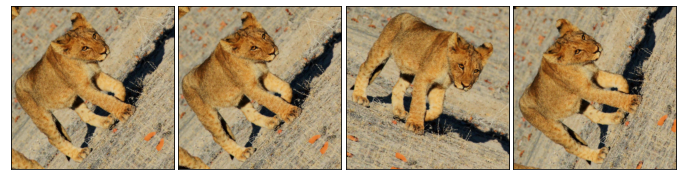

In [41]:
from keras.layers import RandomRotation

sample = load_sample(output_size=(300, 300))
aug_layer = RandomRotation(
    factor = (-0.2, 0.3),
)

apply(sample, aug_layer)

In [42]:
# Alternative Implementation using tf.image
random_rotation = tf.keras.preprocessing.image.random_rotation(sample, rg=500, channel_axis = 2, row_axis=0, col_axis=1)

d. `RandomFlip`  

This layer will flip the images horizontally and or vertically based on the mode attribute.

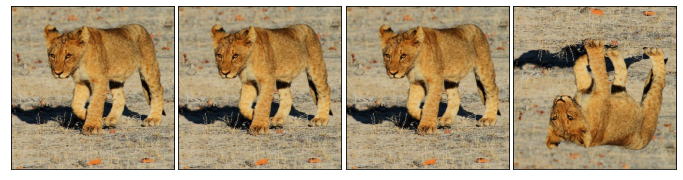

In [43]:
from keras.layers import RandomFlip

sample = load_sample(output_size=(300, 300))
aug_layer = RandomFlip()

apply(sample, aug_layer)

In [44]:
# Alternative Implementation using tf.image
randomflip = tf.image.random_flip_left_right(sample, 10)

e. `RandomBrightness`

This layer will randomly increase/reduce the brightness for the input RGB images. 

This Version of tensorflow doesn't have tensorflow.keras.layers.RandomBrightness class, using tf.image.random_brightness instead


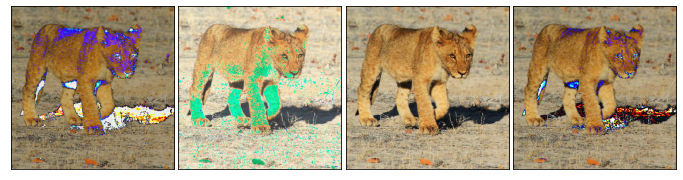

In [45]:
sample = load_sample(output_size=(300, 300))

try:
    from tensorflow.keras.layers import RandomBrightness
    aug_layer = RandomBrightness(factor=(-0.2, 0.5))
except ImportError:
    print("This Version of tensorflow doesn't have tensorflow.keras.layers.RandomBrightness class, using tf.image.random_brightness instead")
    aug_layer = lambda x: tf.image.random_brightness(x, 100)
apply(sample, aug_layer)

In [46]:
# Alternative Implementation using tf.image
random_bright = tf.image.random_brightness(sample, 100)

f. `RandomContrast`

This layer will randomly adjust the contrast of an image or images by a random factor. Contrast is adjusted independently for each channel of each image during training.

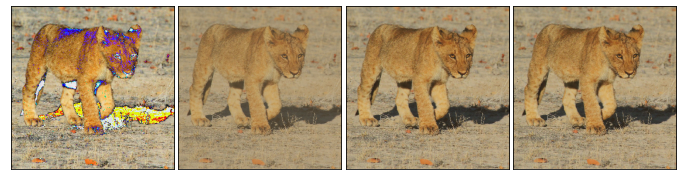

In [47]:
from keras.layers import RandomContrast

sample = load_sample(output_size=(300, 300))
aug_layer = RandomContrast(factor=(0.5, 0.9))

apply(sample, aug_layer)

In [48]:
# Alternative Implementation using tf.image
random_contrast = tf.image.random_contrast(sample, 0.5, 10)

Now let's apply some of the augmentation techniques on the clothing-dataset!

### Modification #5: Apply Data Augmentation

In [57]:
def preprocess_v2(train_data, val_data, test_data, target_height=128, target_width=128):

    # Data Processing Stage with resizing and rescaling operations #same as before for test,val
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Data Processing Stage with resizing and rescaling operations
    data_augmentation = keras.Sequential(
        name="data_augmentation",
        layers=[
            layers.Resizing(156, 156), # First resize to 156,156
            layers.RandomCrop(target_height, target_width), # Then randomly crop 128,128 region
            # layers.RandomBrightness(0.2), # Modify brightness by 0.2 factor
            layers.Rescaling(1.0/255), # Finally rescale
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(
        lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
    val_ds = val_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
    test_ds = test_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [58]:
train_ds, val_ds, test_ds = preprocess_v2(train_data, val_data, test_data)

In [59]:
model = arch_3()
model.summary()

Model: "model_cnn_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 activation_6 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 activation_7 (Activation)   (None, 64, 64, 32)        

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
96/96 [==============================] - 9s 75ms/step - loss: 3.3166 - accuracy: 0.2229 - val_loss: 2.8904 - val_accuracy: 0.0997 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 7s 73ms/step - loss: 2.8677 - accuracy: 0.3155 - val_loss: 3.4083 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 7s 73ms/step - loss: 2.5738 - accuracy: 0.3996 - val_loss: 3.3575 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 7s 74ms/step - loss: 2.3047 - accuracy: 0.4524 - val_loss: 3.0152 - val_accuracy: 0.3284 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 7s 74ms/step - loss: 2.1211 - accuracy: 0.5160 - val_loss: 2.1127 - val_accuracy: 0.4868 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 7s 73ms/step - loss: 1.8771 - accuracy: 0.5714 - val_loss: 2.0392 - val_accuracy: 0.4956 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 8s 83ms/step - lo

In [ ]:
plot_accuracy(model_fit)


In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

**>80% Val Accuracy**  

For the first time ever, we were able to breach 80% val accuracy barrier and also obtained highest ever test accuracy, which shows that Data Augmentation helps.

#### But does Data Augmentation always improve the performance of the model?
* The main idea **how Augmentation works is** `it improve model Performance when we have less data.`
* By increasing the amount of Data.
* So, that our **model can generalize better**.
* **But Data Augmentation improves result till a particular point only.**


# Summary : 

In this lecture, we covered:

- How to Code Convolution and Max Pooling layers from scratch!
- Batch Normalization
- Dropout
- L1 and L2 Regularization
- Data Augmentation Techniques

In the next class, we will discuss about forward and backward propagation in CNN components.